## Sentiment Classification using Pre-Trained Roberta Model

Model Source: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

In [2]:
import pandas as pd
import numpy as np
import torch
import torchtext
import torchdata
import portalocker
from wordsegment import load, segment
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
from itertools import combinations
from torchtext.vocab import GloVe

from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request


torch.manual_seed(0)

task='sentiment'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

### Testing the model on the kaggle tweets dataset

In [16]:
tweets_analysis = pd.read_csv("kaggle_clean.csv")

In [64]:
tweets_analysis['label'] = 0
tweets_analysis.loc[(tweets_analysis.loc[:, "sentiment"] == 'positive'), 'label'] = 2
tweets_analysis.loc[(tweets_analysis.loc[:, "sentiment"] == 'neutral'), 'label'] = 1

In [68]:
df = tweets_analysis.loc[:, ["label", "sentiment", "text_clean"]]

In [7]:
labels=[]
mapping_link = f"https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/{task}/mapping.txt"
with urllib.request.urlopen(mapping_link) as f:
    html = f.read().decode('utf-8').split("\n")
    csvreader = csv.reader(html, delimiter='\t')
labels = [row[1] for row in csvreader if len(row) > 1]


In [9]:
# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
model.save_pretrained(MODEL)

In [10]:
text = df["text_clean"][0]
#text = preprocess(text)
encoded_input = tokenizer(text, return_tensors='pt')
output = model(**encoded_input)
scores = output[0][0].detach().numpy()
scores = softmax(scores)

In [70]:
class CustomTextDataset(Dataset):
    def __init__(self, txt, labels):
        self.labels = labels
        self.text = txt
        #self.city = city
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        text = self.text[idx]
        #city = self.city[idx]
        sample = {"Text": text, "Class": label}
        return (label, text)

In [71]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


def collate_fn(batch):
    k = len(batch)
    label_list, original_text, text_list = [], [], []
    
    max_words = 0
    for i, (label, text) in enumerate(batch): 
        label_list.append(label)
        original_text.append(str(text))
        text = tokenizer(str(text), return_tensors = 'pt')
        text_list.append(text)
    label_list = torch.tensor(label_list, dtype = torch.int64)
    #text_list = torch.tesnor(text)
    return original_text, label_list, text_list

In [72]:
TD = CustomTextDataset(df['text_clean'], df['label'])

In [73]:
dataloader = DataLoader(TD, batch_size=1000, shuffle=False, 
                        collate_fn=collate_fn)

for idx, (_, lt, tt) in enumerate(dataloader):
    print(idx, lt.shape, len(tt))
    if idx == 4: 
        break

0 torch.Size([1000]) 1000
1 torch.Size([1000]) 1000
2 torch.Size([1000]) 1000
3 torch.Size([1000]) 1000
4 torch.Size([1000]) 1000


In [74]:
preds = []
correct = []
correct_count = 0
total = 0
original_text = []

for i, (ot, lt, tt) in enumerate(dataloader):
    total += len(lt)
    print("beginning dataloader", i)
    for i, t in enumerate(tt):
        original_text.append(ot[i])
        correct.append(lt[i])
        output = model(**t)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        prediction = np.argmax(scores)
        preds.append(prediction)
        if prediction == lt[i]:
            correct_count += 1
    print("current accuracy:", correct_count/total)

beginning dataloader 0
current accuracy: 0.729
beginning dataloader 1
current accuracy: 0.723
beginning dataloader 2
current accuracy: 0.724
beginning dataloader 3
current accuracy: 0.724
beginning dataloader 4
current accuracy: 0.7256
beginning dataloader 5
current accuracy: 0.7256666666666667
beginning dataloader 6
current accuracy: 0.7254285714285714
beginning dataloader 7
current accuracy: 0.72875
beginning dataloader 8
current accuracy: 0.7272222222222222
beginning dataloader 9
current accuracy: 0.7282
beginning dataloader 10
current accuracy: 0.7271818181818182
beginning dataloader 11
current accuracy: 0.7280833333333333
beginning dataloader 12
current accuracy: 0.7276153846153847
beginning dataloader 13
current accuracy: 0.7270714285714286
beginning dataloader 14
current accuracy: 0.7268
beginning dataloader 15
current accuracy: 0.7266875
beginning dataloader 16
current accuracy: 0.7261764705882353
beginning dataloader 17
current accuracy: 0.7264444444444444
beginning dataloader

In [77]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [78]:
cm = confusion_matrix(correct, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

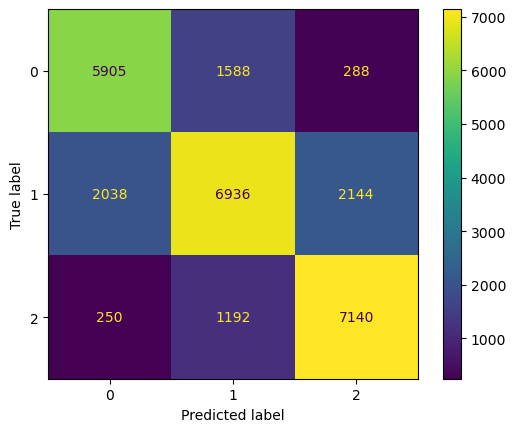

In [84]:
disp.plot()

### Applying the Model to our City Tweets

In [116]:
#Create custom dataset
from torch.utils.data import Dataset

class CustomTextDataset(Dataset):
    def __init__(self, txt, city, id_num):
        self.text = txt
        self.city = city
        self.id = id_num
    def __len__(self):
        return len(self.id)
    def __getitem__(self, idx):
        text = self.text[idx]
        city = self.city[idx]
        id_num = self.id[idx]
        #sample = {"Text": text, "Class": label}
        return (text, city, id_num)

In [117]:
def collate_fn(batch):
    k = len(batch)
    id_list, original_text, cities, text_list = [], [], [], []
    
    max_words = 0
    for i, (text, city, id_num) in enumerate(batch): 
        #label_list.append(label)
        original_text.append(str(text))
        text = tokenizer(str(text), return_tensors = 'pt')
        text_list.append(text)
        id_list.append(id_num)
        cities.append(city)
    #label_list = torch.tensor(label_list, dtype = torch.int64)
    #text_list = torch.tesnor(text)
    return original_text, text_list, cities, id_list

In [118]:
df = pd.read_csv("final_tweets_set.csv")

In [119]:
df = df[["id", "text", "city", "inside", "text_clean"]]

In [120]:
TD = CustomTextDataset(df['text_clean'], df['city'], df['id'])

In [142]:
dataloader = DataLoader(TD, batch_size=1000, shuffle=False, 
                        collate_fn=collate_fn)

In [143]:
#label = []
original_text = []
cities = []
preds = []
ids = []
for i, (ot, text_list, city, id_list) in enumerate(dataloader):
    total += len(lt)
    print("beginning dataloader", i)
    for i, t in enumerate(text_list):
        original_text.append(ot[i])
        #correct.append(lt[i])
        output = model(**t)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        prediction = np.argmax(scores)
        preds.append(prediction)
    cities.extend(city)
    ids.extend(id_list)

beginning dataloader 0
beginning dataloader 1
beginning dataloader 2
beginning dataloader 3
beginning dataloader 4
beginning dataloader 5
beginning dataloader 6
beginning dataloader 7
beginning dataloader 8
beginning dataloader 9
beginning dataloader 10
beginning dataloader 11
beginning dataloader 12
beginning dataloader 13
beginning dataloader 14
beginning dataloader 15
beginning dataloader 16
beginning dataloader 17
beginning dataloader 18
beginning dataloader 19
beginning dataloader 20
beginning dataloader 21
beginning dataloader 22
beginning dataloader 23
beginning dataloader 24
beginning dataloader 25
beginning dataloader 26
beginning dataloader 27


54782

In [144]:
sent_tweets = {"id": ids, "original_text": original_text,
               "city": cities, "sentiment": preds}

In [146]:
len(ids)

27200

In [147]:
sent_tweets_df = pd.DataFrame(sent_tweets, columns = ["id", "original_text", "city", "sentiment"])

In [153]:
out = sent_tweets_df.groupby(['city',])['sentiment'].value_counts(normalize=True)

In [167]:
pd.DataFrame(out)

sentiment
city          sentiment           
Boston        1           0.481875
              2           0.420625
              0           0.097500
Chicago       1           0.505625
              2           0.398750
              0           0.095625
Fort Worth    1           0.675000
              2           0.193750
              0           0.131250
Jacksonville  1           0.602500
              2           0.341875
              0           0.055625
Kansas City   1           0.515000
              2           0.424375
              0           0.060625
Las Vegas     1           0.548750
              2           0.380625
              0           0.070625
Los Angeles   1           0.576875
              2           0.360000
              0           0.063125
New Orleans   1           0.563125
              2           0.376250
              0           0.060625
New York      1           0.577500
              2           0.362500
              0           0.060000
Philadelphia  1           0.650000
              2           0.215000
              0           0.135000
Phoenix       1           0.570000
              2           0.351875
              0           0.078125
Pittsburgh    1           0.510625
              2           0.413125
              0           0.076250
Raleigh       1           0.573750
              2           0.373125
              0           0.053125
San Antonio   1           0.564375
              2           0.366250
              0           0.069375
San Francisco 1           0.563125
              2           0.368125
              0           0.068750
Tampa         1           0.574375
              2           0.358750
              0           0.066875
Washington DC 1           0.519375
              2           0.364375
              0           0.116250

In [156]:
sent_sub = sent_tweets_df[["id", "sentiment"]]

In [161]:
tweets_analysis = pd.read_csv("final_tweets_set.csv")

In [163]:
new_tweets = tweets_analysis.merge(sent_sub, on = "id", how = "inner")

In [165]:
new_tweets.to_csv("final_tweets_set_roberta_sentiment.csv")